# Boosting

In [47]:
import numpy as np
import pandas as pd
import matplotlib 
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, roc_curve, auc, plot_confusion_matrix, RocCurveDisplay, confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.ensemble import GradientBoostingClassifier

from preprocessing import *

plt.rcParams["figure.dpi"] = 60

# Carga del dataset
Leemos el dataset y lo separamos en datos de training y de evaluación.

In [43]:
df = pd.read_csv("df_train.csv")
X = df.drop(columns=['llovieron_hamburguesas_al_dia_siguiente'])
y = df['llovieron_hamburguesas_al_dia_siguiente']
X_train, X_eval, y_train, y_eval = train_test_split(X, y, random_state=117, test_size=0.1, stratify=y.astype(str))

# Selección de modelos

Para encontrar el mejor modelo, probaremos utilizando 2 preprocesamientos distintos. Dado que boosting es un ensamble de árboles, los preprocesamientos serán los mismos que usamos para los árboles de decisión (particularmente el 1 y el 2, ya que son los que obtuvieron mejores resultados en el notebook de árboles). Por cada uno de ellos, buscaremos la mejor combinación de hiperparámetros mediante Randomized Search, con el objetivo de maximizar la métrica AUC ROC. Dado que el entrenamiento de un modelo de Boosting toma un tiempo mayor que otros modelos, solamente haremos 10 iteraciones con 3 folds de cross-validation en lugar de 5.

Los hiperparámetros que buscaremos son:
- **max_depth:** es la máxima profundidad que pueden tener los árboles.
- **n_estimators:** es la cantidad de árboles que forman parte del ensamble. Dado que los árboles no son muy complejos (tienen una profundidad menor que 3), buscamos utilizar una cantidad alta de estimadores (entre 50 y 150) para que el modelo clasifique correctamente la mayor cantidad de instancias.
- **learning_rate:** es la ponderación de cada estimador, es decir, cuánto influye cada árbol en la predicción global. Al tener una gran cantidad de estimadores, es conveniente usar un learning rate bajo, entre 0.1 y 0.5.


En primer lugar probamos con el dataset completo, codificando las variables categóricas con One Hot Encoding:

In [29]:
X_train1 = preprocessing_arboles_1(X_train)
params = {
    'n_estimators': np.arange(50, 150),
    'learning_rate': np.arange(0.1, 0.5, 0.1),
    'max_depth': np.arange(1, 3),
}

clf = GradientBoostingClassifier(random_state=0)

rgscv = RandomizedSearchCV(
    clf, params, n_iter = 10, scoring='roc_auc', n_jobs=-1, cv=3, return_train_score=True
).fit(X_train1, y_train)

print(f"Best score: {rgscv.best_score_}")
print(f"Best params {rgscv.best_params_}")

Best score: 0.8778375726887907
Best params {'n_estimators': 87, 'max_depth': 2, 'learning_rate': 0.4}


El segundo preprocesamiento elimina los features categóricos:

In [4]:
X_train2 = preprocessing_arboles_2(X_train)
params = {
    'n_estimators': np.arange(50, 150),
    'learning_rate': np.arange(0.1, 0.5, 0.1),
    'max_depth': np.arange(1, 3),
}

clf = GradientBoostingClassifier(random_state=0)


rgscv = RandomizedSearchCV(
    clf, params,  n_iter = 10, scoring='roc_auc', n_jobs=-1, cv=3, return_train_score=True
).fit(X_train2, y_train)

print(f"Best score: {rgscv.best_score_}")
print(f"Best params {rgscv.best_params_}")

Best score: 0.87018785845494
Best params {'n_estimators': 87, 'max_depth': 2, 'learning_rate': 0.2}


Podemos observar que en ambos casos los valores del número de estimadores y de la profundidad máxima fueron los mismos. Al igual que sucedió en la búsqueda de hiperparámetros de los árboles de decisión, el preprocesamiento que obtuvo un mejor score fue el primero, que corresponde al dataset completo.

# Evaluación del modelo final

El mejor modelo encontrado corresponde al preprocesamiento preprocessing_arboles_1, con los hiperparametros 'n_estimators': 87, 'max_depth': 2, 'learning_rate': 0.4.
Entrenamos el modelo y evaluamos utilizando el set de evaluacion.

In [44]:
X_eval = preprocessing_arboles_1(X_eval)

clf = GradientBoostingClassifier(n_estimators=87, max_depth=2, learning_rate=0.4)
clf.fit(X_train1, y_train)

y_pred = clf.predict(X_eval)
y_pred_proba = clf.predict_proba(X_eval)[:,1]

In [45]:
print(f"Auc Roc: {roc_auc_score(y_eval, y_pred_proba)}")
print(f"Accuracy: {accuracy_score(y_eval, y_pred)}")
print(f"Precision: {precision_score(y_eval, y_pred)}")
print(f"Recall: {recall_score(y_eval, y_pred)}")
print(f"F1 Score: {f1_score(y_eval, y_pred)}")

Auc Roc: 0.8820251829944754
Accuracy: 0.854102128510043
Precision: 0.7355163727959698
Recall: 0.5289855072463768
F1 Score: 0.6153846153846154


De las métricas podemos destacar que se obtuvo un accuracy de 0.85, mayor que el accuracy del baseline obtenido en el TP1 (0.83). Dado que el accuracy no es una buena métrica para evaluar un modelo cuando se usa un dataset desbalanceado como este, la métrica que usamos para comparar los modelos es AUC, la cual tiene un valor de 0.88.

También vemos que el recall obtenido (0.53) es mucho menor que el precision (0.74). Esto significa que, de todas las instancias que son realmente positivas (es decir, llueven hamburguesas al día siguiente), el modelo solo detecta correctamente el 53% de ellas. Por otro lado, de las que el modelo predice como positivas, el 74% eran realmente positivas.

Por último, el F1 Score permite tener una única métrica para evaluar el modelo, teniendo en cuenta el recall y el precision:

    F1 = 2 x (precision x recall) / (precision + recall) = 0.62

Para analizar con más detalle estas métricas, graficaremos la matriz de confusión y la curva ROC.

## Matriz de confusion

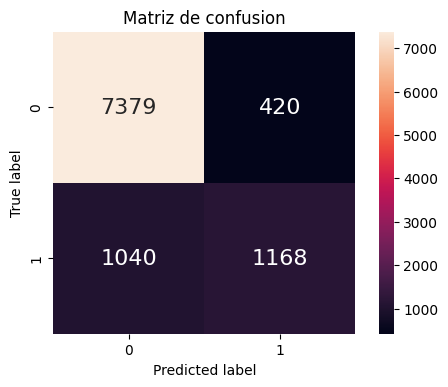

In [48]:
names = sorted(set(y_eval))
cm = confusion_matrix(y_eval, y_pred)
df_cm = pd.DataFrame(cm, names, names)

plt.figure(dpi=100)
plt.title("Matriz de confusion")
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', square=True)
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

En la matriz de confusión podemos observar exactamente cuántas instancias fueron predichas como True Positive, True Negative, False Positive y False Negative. A partir de estos datos se pueden calcular las métricas, verificando los resultados obtenidos anteriormente:
- Recall = TP/(TP+FN) = 1168/(1168+1040) = 0.53
- Precision = TP/(TP+FP) = 1168/(1168+420) = 0.74
- Accuracy = (TP+TN)/total = 8547/10007 = 0.85

## Curva ROC

La curva ROC se obtiene al graficar el True Positive Rate (Recall) vs el False Positive Rate, variando el umbral de detección entre 0 y 100%. Si las predicciones hechas fueran completamente aleatorias, la curva sería una recta, con un área bajo la curva de 0.5. El área bajo la curva es la métrica que se obtiene de la curva, y por eso se busca obtener valores mayores que 0.5. En este caso se obtuvo un AUC = 0.88, el cual es un buen valor comparado con otros modelos utilizados en este TP.

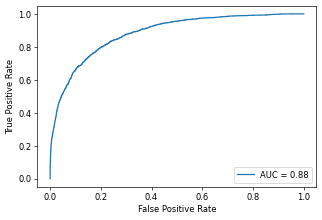

In [36]:
fpr, tpr, thresholds = roc_curve(y_eval, y_pred_proba)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()
plt.show()

# Predicciones finales
Finalmente, utilizaremos el modelo para predecir la lluvia de hamburguesas a partir de datos que no fueron usados en el entrenamiento. Guardaremos las predicciones en un archivo csv.

In [37]:
X_train2 = preprocessing_arboles_1(X_train)

clf = GradientBoostingClassifier(n_estimators=87, max_depth=2, learning_rate=0.2)
clf.fit(X_train1, y_train)

df_pred = pd.read_csv("pred.csv")
df_pred_preprocess = basic_preprocessing(df_pred, prediction_dataset=True)
df_pred_preprocess = fill_numerical_missings(df_pred_preprocess, X_train)
df_pred_preprocess = df_pred_preprocess.drop(columns = ['id'])
df_pred_preprocess = preprocessing_arboles_1(df_pred_preprocess)

y_pred_final = clf.predict(df_pred_preprocess)
df_pred_final = pd.DataFrame({'id': df_pred['id'], 'llovieron_hamburguesas_al_dia_siguiente': y_pred_final})
df_pred_final.loc[df_pred_final['llovieron_hamburguesas_al_dia_siguiente'] == 1, 'llovieron_hamburguesas_al_dia_siguiente'] = 'si'
df_pred_final.loc[df_pred_final['llovieron_hamburguesas_al_dia_siguiente'] == 0, 'llovieron_hamburguesas_al_dia_siguiente'] = 'no'

df_pred_final['llovieron_hamburguesas_al_dia_siguiente'].value_counts()



no    24761
si     4331
Name: llovieron_hamburguesas_al_dia_siguiente, dtype: int64

In [38]:
df_pred_final.to_csv('predicciones/boosting.csv', index=False)